## imports & installations

In [2]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import os
import datetime

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))


import analysis.calc_single_cell_properties as calculator 
import analysis.calc_auc_over_time as auc_calculator 
import analysis.utils as utils
import model_layer.utils as model_utils
import data_layer.utils as data_utils
from configuration import consts

In [3]:
fig_dir_path = fr"/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/eps_figs/"

## data loading - differentiation scores dataframes

In [4]:
scores_df_s3 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

Calculate single cell properties

In [5]:
scores_df_s3 = calculator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.vid_info_dict["3"]['actin_path'])
scores_df_s2 = calculator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.vid_info_dict["2"]['actin_path'])
scores_df_s5 = calculator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.vid_info_dict["5"]['actin_path'])
scores_df_s1 = calculator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.vid_info_dict["1"]['actin_path'])

# Models' performance

display models performance- actin intensity/motility seperately. 

We will display the following metrics:
1. accuracy
2. specificity
3. sensitivity 
4. precision
5. AUC

We will display the following graphs:
1. ROC curve
2. AUC over time

We will now combine the actin and motility time series, train a new model and assess its performance.

In [6]:
%load_ext autoreload
%autoreload 2

In [35]:
def build_combined_model(con_test_n, diff_test_n, con_train_n, diff_train_n, saving_path):
    # load motility data
    data_path = consts.motility_model_path % (con_train_n, diff_train_n)
    _, x_train_mot, x_test_mot, y_train_mot, y_test_mot = data_utils.load_data(data_path, load_clf=True, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
    
    # load actin_intensity data
    data_path = consts.intensity_model_path % (con_train_n, diff_train_n)
    _, x_train_int, x_test_int, y_train_int, y_test_int = data_utils.load_data(data_path, load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
    
    # combine features
    x_train = x_train_mot.merge(x_train_int, on="Spot track ID", how="right")
    x_test = x_test_mot.merge(x_test_int, on="Spot track ID", how="right")
    y_train = y_train_mot.merge(y_train_int, on=["Spot track ID", "target"], how="right")
    y_test = y_test_mot.merge(y_test_int, on=["Spot track ID", "target"], how="right")
    combined_clf = model_utils.train_model(x_train.drop(columns=['Spot track ID']), y_train["target"], modality=None)
    # save data & model 
    os.makedirs(saving_path, exist_ok=True)
    data_utils.save_data(saving_path, clf=combined_clf, X_train=x_train, X_test=x_test, y_train=y_train, y_test=y_test)
    del x_train
    del y_train
    utils.evaluate_model(combined_clf, x_test, y_test, modality="combined", con_test_n=con_test_n, diff_test_n=diff_test_n)
    
    return combined_clf

Evaluation metrics for combined based model, tested on videos (s2, s3):
accuracy: 0.814
specificity: 0.911
sensitivity (recall): 0.783
precision: 0.966
AUC: 0.847


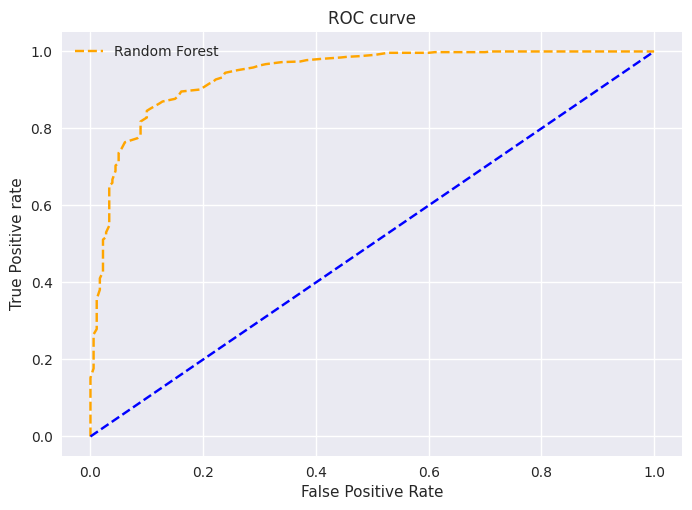

KeyboardInterrupt: 

<Figure size 800x550 with 0 Axes>

In [50]:
train_vid_nums = [(1,5), (2,3)]
test_vid_nums = [(2,3), (1,5)]

for (con_train_n, diff_train_n), (con_test_n, diff_test_n) in zip(train_vid_nums, test_vid_nums):
    saving_path = f"{consts.storage_path}{datetime.datetime.now().strftime('%d-%m-%Y')}- combined motility & actin features, s{con_train_n}, s{diff_train_n} train"
    combined_clf = build_combined_model(con_test_n, diff_test_n, con_train_n, diff_train_n, saving_path)
    cols = list(combined_clf.feature_names_in_) + ["Spot track ID", "Spot frame"]

    # calculate single cells differentiation trajectories   
    for test_n in (con_test_n, diff_test_n):
        tsfresh_df = data_utils.load_tsfresh_transformed_df("combined", test_n)
        tsfresh_df = tsfresh_df[cols]
        if not os.path.exists(saving_path + f"/df_score_vid_num_S{test_n}.pkl"):
            print("calculating diff scores single cell trajectories")
            df_score = utils.calc_prob(tsfresh_df.dropna(axis=1), combined_clf, n_frames=260)
            pickle.dump(df_score, open(saving_path + f"/df_score_vid_num_S{test_n}.pkl", 'wb'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


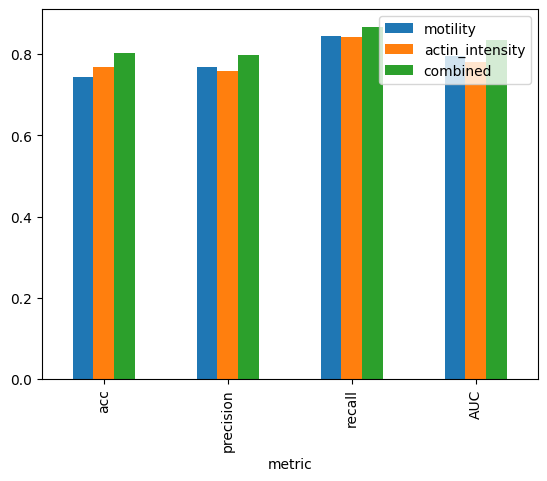

In [13]:
df = pd.DataFrame()
df = df.append({"motility": np.mean([0.76, 0.727]), "actin_intensity": np.mean([0.808, 0.73]), "combined": np.mean([0.831, 0.774]), "metric": "acc"}, ignore_index=True)
df = df.append({"motility": np.mean([0.965, 0.573]), "actin_intensity": np.mean([0.927, 0.591]), "combined": np.mean([0.966, 0.631]), "metric": "precision"}, ignore_index=True)
df = df.append({"motility": np.mean([0.711, 0.978]), "actin_intensity": np.mean([0.813, 0.873]), "combined": np.mean([0.801, 0.933]), "metric": "recall"}, ignore_index=True)
df = df.append({"motility": np.mean([0.814, 0.78]), "actin_intensity": np.mean([0.804, 0.76]), "combined": np.mean([0.864, 0.807]), "metric": "AUC"}, ignore_index=True)

df.plot(x="metric", y=["motility", "actin_intensity", "combined"], kind="bar")
plt.grid(False)
plt.savefig(fig_dir_path + f"/combined_vs_single_modality_barplot.eps", format="eps")

In [14]:
round(df, 2)

,motility,actin_intensity,combined,metric
0,0.74,0.77,0.80,acc
1,0.77,0.76,0.80,precision
2,0.84,0.84,0.87,recall
3,0.80,0.78,0.84,AUC


Let's see the differentiation score over time for the motility & actin intensity combined model

In [41]:
# load single cells differentiation trajectories dataframes
combined_scores_path = f"{consts.storage_path}13-05-2023- combined motility & actin features, s%s, s%s train/"

scores_df_combined_s2 = utils.convert_score_df(pickle.load(open(combined_scores_path % (1,5) +"df_score_vid_num_S2.pkl", 'rb'))  , "combined")
scores_df_combined_s3 = utils.convert_score_df(pickle.load(open(combined_scores_path % (1,5) +"df_score_vid_num_S3.pkl", 'rb'))  , "combined")

scores_df_combined_s1 = utils.convert_score_df(pickle.load(open(combined_scores_path % (2,3) +"df_score_vid_num_S1.pkl", 'rb'))  , "combined")
scores_df_combined_s5 = utils.convert_score_df(pickle.load(open(combined_scores_path % (2,3) +"df_score_vid_num_S5.pkl", 'rb'))  , "combined")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


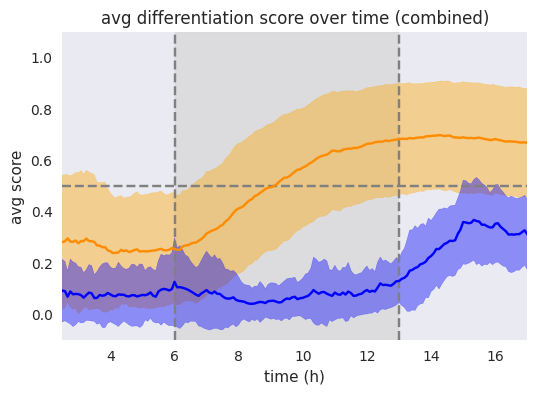

<Figure size 800x550 with 0 Axes>

In [48]:
data_2_3_test  = [(scores_df_combined_s3, "ERKi", "DarkOrange","Orange"), (scores_df_combined_s2, "DMSO", "blue", "blue"),]
utils.plot_avg_conf(data_2_3_test, "combined", path=fig_dir_path + "avg diff over time train (1,5) test (2,3) combined", plot_std=True, time=(6,13), xlim=(2.5, 17))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


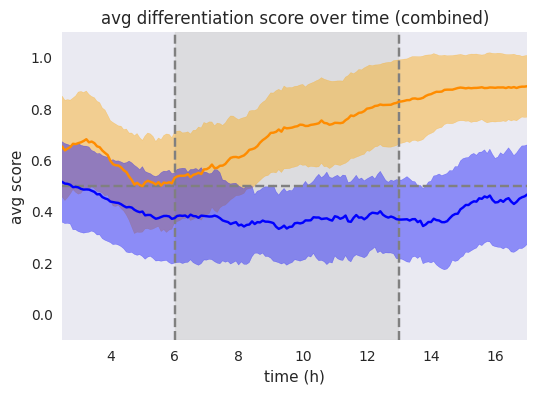

<Figure size 800x550 with 0 Axes>

In [49]:
data_1_5_test  = [(scores_df_combined_s5, "ERKi", "DarkOrange","Orange"), (scores_df_combined_s1, "DMSO", "blue", "blue"),]
utils.plot_avg_conf(data_1_5_test, "combined", path=fig_dir_path + "avg diff over time train (2,3) test (1,5) combined", plot_std=True, time=(6,13), xlim=(2.5, 17))